In [95]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomTreesEmbedding
import pickle
%matplotlib inline

### Loading the Book Ratings Dataset

Loading directly the pre-processed dataset.

In [485]:
data = pd.read_csv('../created_datasets/Combine.csv')

In [316]:
rows = data.user_id.unique()
cols = data['isbn'].unique()

In [317]:
print("Sparsity :", 100 - (data.shape[0]/(len(cols)*len(rows)) * 100))

Sparsity : 99.21241009430905


In [318]:
idict  = dict(zip(cols, range(len(cols))))
udict = dict(zip(rows, range(len(rows))))

data.user_id = [
    udict[i] for i in data.user_id
]
data['isbn'] = [
    idict[i] for i in data['isbn']#['Book-Title'] ##
]

nmat = data.as_matrix()


#### Function for Evaluation Metrics: MAE and RMSE

In [319]:
def rmse(ypred, ytrue):
    ypred = ypred[ytrue.nonzero()].flatten()
    ytrue = ytrue[ytrue.nonzero()].flatten()
    return np.sqrt(mean_squared_error(ypred, ytrue))

def mae(ypred, ytrue):
    ypred = ypred[ytrue.nonzero()].flatten()
    ytrue = ytrue[ytrue.nonzero()].flatten()
    return mean_absolute_error(ypred, ytrue)

Our Naive Baseline for any user i, item j prediction is to assign it with (sum of mean rating given by user i (umean[i]), mean rating received by item j (imean[j]) substracting average rating over entire dataset. (amean)) <br><br>
-------------- Naive Baseline ---------------


In [320]:
def predict_naive(user, item):
    prediction = imean1[item] + umean1[user] - amean1
    return prediction

In [321]:
x1, x2 = train_test_split(nmat, test_size = 0.2, random_state =42)
naive = np.zeros((len(rows),len(cols)))
for row in x1:
    naive[row[0].astype(int), row[1].astype(int)] = row[2]

predictions = []
targets = []

amean1 = np.mean(naive[naive!=0])
umean1 = sum(naive.T) / sum((naive!=0).T)
imean1 = sum(naive) / sum((naive!=0))

umean1 = np.where(np.isnan(umean1), amean1, umean1)
imean1 = np.where(np.isnan(imean1), amean1, imean1)


print('Naive---')
for row in x2:
    user, item, actual = row[0], row[1], row[2]
    predictions.append(predict_naive(user.astype(int), item.astype(int)))
    targets.append(actual)

print('rmse %.4f' % rmse(np.array(predictions), np.array(targets)))
print('mae %.4f' % mae(np.array(predictions), np.array(targets)))
print()

C:\Users\apawar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Naive---
rmse 0.8252
mae 0.6209



Following are the functions to calculate pairwise similarity between two items : Cosine, Adjusted Cosine, Euclidean, Pearson Corelation.

In [135]:
def cos(mat, a, b):
    if a == b:
        return 1
    aval = mat.T[a].nonzero()
    bval = mat.T[b].nonzero()
    corated = np.intersect1d(aval, bval)
    if len(corated) == 0:
        return 0
    avec = np.take(mat.T[a], corated)
    bvec = np.take(mat.T[b], corated)
    val = 1 - cosine(avec, bvec)
    if np.isnan(val):
        return 0
    return val

In [136]:
def adjcos(mat, a, b, umean):
    if a == b:
        return 1
    aval = mat.T[a].nonzero()
    bval = mat.T[b].nonzero()
    corated = np.intersect1d(aval, bval)
    if len(corated) == 0:
        return 0
    avec = np.take(mat.T[a], corated)
    bvec = np.take(mat.T[b], corated)
    avec1 = avec - umean[corated]
    bvec1 = bvec - umean[corated]
    val = 1 - cosine(avec1, bvec1)
    if np.isnan(val):
        return 0
    return val

In [137]:
def pr(mat, a, b, imean):
    if a == b:
        return 1
    aval = mat.T[a].nonzero()
    bval = mat.T[b].nonzero()
    corated = np.intersect1d(aval, bval)
    if len(corated) < 2:
        return 0
    avec = np.take(mat.T[a], corated)
    bvec = np.take(mat.T[b], corated)
    avec1 = avec - imean[a]
    bvec1 = bvec - imean[b]
    val = 1 - cosine(avec1, bvec1)
    if np.isnan(val):
        return 0
    return val

In [138]:
def euc(mat, a, b):
    if a == b:
        return 1
    aval = mat.T[a].nonzero()
    bval = mat.T[b].nonzero()
    corated = np.intersect1d(aval, bval)
    if len(corated) == 0:
        return 0
    avec = np.take(mat.T[a], corated)
    bvec = np.take(mat.T[b], corated)
    dist = np.sqrt(np.sum(a-b)**2)
    val = 1/(1+dist)
    if np.isnan(val):
        return 0
    return val

Predict function is used to get recommended rating by user i for item j.

In [139]:
def predict(user, item, mat, item_similarity, amean, umean, imean,  k=20):
    nzero = mat[user].nonzero()[0]
    if len(nzero) == 0:
        return amean
    baseline = imean + umean[user] - amean
    choice = nzero[item_similarity[item, nzero].argsort()[::-1][1:k+1]]
    prediction = ((mat[user, choice] - baseline[choice]).dot(item_similarity[item, choice])/ sum(item_similarity[item, choice])) + baseline[item]
        
    if np.isnan(prediction):
        prediction = amean
    if prediction > 10:
        prediction = 10
    if prediction < 1:
        prediction = 1
    return prediction

itemsimilar function is used to get similarities between items

In [360]:
def itemsimilar(mat, option, indices='nope'): #item-item
    amean = np.mean(mat[mat!=0])
    umean = sum(mat.T) / sum((mat!=0).T)
    imean = sum(mat) / sum((mat!=0))
    
    umean = np.where(np.isnan(umean), amean, umean)
    imean = np.where(np.isnan(imean), amean, imean)
    
    n = mat.shape[1]
    sim_mat = np.ones((n, n))*0
    
    if option == 'pr':
        for i in range(n):
            for j in range(n):
                sim_mat[i][j] = pr(mat, i, j, imean)
        sim_mat = (sim_mat + 1)/2
    elif option == 'cos':
        for i in range(n):
            for j in range(n):
                sim_mat[i][j] = cos(mat, i, j)
    elif option == 'adjcos':
        for i in range(n):
            for j in range(n):
                sim_mat[i][j] = adjcos(mat, i, j, umean)
        sim_mat = (sim_mat + 1)/2
    elif option == 'euc':
        if indices=='nope':
            for i in range(n):
                for j in range(n):
                    sim_mat[i][j] = euc(mat, i, j)            
        else:
            for i in indices:
                for j in indices:
                    sim_mat[i][j] = euc(mat, i, j)
    else:
        sim_mat = cosine_similarity(mat.T)
    
    return sim_mat, amean, umean, imean

itemsimilar_ann() uses itemsimilar() to find closest items using tree based ANN

In [481]:
def itemsimilar_ann(tree, mat, k, items, recalculate=False):
    n=tree.shape[1]
    for i in range(n):
        indices = np.argwhere(tree[:, i]==1).flatten()
        indices_none = np.argwhere(tree[:, i]!=1).flatten()
        if recalculate==True:
            item_similarity1, amean1, umean1, imean1 = itemsimilar(mat, 'cos', indices)
        else:
            item_similarity1 = items.copy()
            for m in indices_none:
                item_similarity1[m] = 0
        if i==0:
            item_similarity_all = item_similarity1.copy()
            item_similarity_all[:,:] = 0
            item_similarity_agg = item_similarity_all.copy()
            closest_items = item_similarity_all.copy()
            item_similarity_final = item_similarity_all.copy()

        no_data = item_similarity_all==0
        item_similarity_all[no_data] = item_similarity_all[no_data] + item_similarity1[no_data] 

        for j in indices:
            a = item_similarity1[j].copy()
            # item_similarity_agg counts number of times the item came as closest to the jth item.
            item_similarity_agg[j] = item_similarity_agg[j] + (a>=np.amax([0.00001, (-1*np.partition(-a, k-1, axis=-1)[k-1])])).astype(int)

    for j in range(mat.shape[1]):
        b = item_similarity_agg[j].copy()
        closest_items[j] = (b>=np.amax([0.00001, (-1*np.partition(-b, k-1, axis=-1)[k-1])])).astype(int)

    item_similarity_final[closest_items>0] = item_similarity_all[closest_items>0]
    return(item_similarity_final)

### Grid Search for best K for item-item CF using all the similarity metric implemented.

In [219]:
start = time.time()
full_mat = np.zeros((len(rows), len(cols)))

for row in nmat:
    full_mat[row[0].astype(int), row[1].astype(int)] = row[2]

#item_similarity, amean, umean, imean = itemsimilar(full_mat, 'cos')

# this .pkl file can be accessed on google drive. Takes 5-10 hours to create this file: http://bit.ly/2CkBOjk
item_similarity = pickle.load(open("items_similarity_mat.pkl", "rb" )) 

1.3355786800384521


In [338]:
amean = np.mean(full_mat[full_mat!=0])
umean = sum(full_mat.T) / sum((full_mat!=0).T)
imean = sum(full_mat) / sum((full_mat!=0))

umean = np.where(np.isnan(umean), amean, umean)
imean = np.where(np.isnan(imean), amean, imean)

In [340]:
from sklearn.random_projection import GaussianRandomProjection
grp = GaussianRandomProjection(n_components=10, eps=0.1, random_state=None)
W = grp.fit_transform(np.transpose(full_mat))
print(W.shape)

(4959, 10)

In [447]:
rte = RandomTreesEmbedding(n_estimators=10, max_depth=1000, min_samples_split=30, min_samples_leaf=30,sparse_output=False, random_state=12)
tree = rte.fit_transform(W)#np.transpose(full_mat)
print(tree.shape)
tree = tree[:,~(sum(tree)==tree.shape[0])]
sum(tree)

(4959, 25)


array([   94.,   514.,   118.,   197.,  1353.,  2683.,   833.,   169.,
          39.,   934.,   140.,   452.,   107.,    52.,   645.,  1588.,
         151.,  4808.])

In [482]:
ks = [2, 3, 5, 8, 10, 15, 20, 25]
trmse_list = []
tmae_list = []
for k in ks:
    preds = []
    real = []
    item_similarity_ann = itemsimilar_ann(tree, full_mat, k=k, items = item_similarity)
    print('Item similarity for items in same leaf computed')
    for row in nmat:
        user_id, isbn, rating = row[0], row[1], row[2]
        preds.append(predict(user_id.astype(int), isbn.astype(int), full_mat, item_similarity_ann, amean, umean, imean, k=20))
        real.append(rating)

    err1 = rmse(np.array(preds), np.array(real))
    err2 = mae(np.array(preds), np.array(real))
    trmse_list.append(err1)
    tmae_list.append(err2)
    
    print(k)
    print('Errors')
    print('RMSE : %.4f' % err1)
    print('MAE : %.4f' % err2)

Item similarity for items in same leaf computed


C:\Users\apawar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2
Errors
RMSE : 0.9081
MAE : 0.7151
Item similarity for items in same leaf computed
3
Errors
RMSE : 0.8872
MAE : 0.6893
Item similarity for items in same leaf computed
5
Errors
RMSE : 0.8425
MAE : 0.6371
Item similarity for items in same leaf computed
8
Errors
RMSE : 0.7909
MAE : 0.5811
Item similarity for items in same leaf computed
10
Errors
RMSE : 0.7736
MAE : 0.5622
Item similarity for items in same leaf computed
15
Errors
RMSE : 0.7629
MAE : 0.5511
Item similarity for items in same leaf computed
20
Errors
RMSE : 0.7618
MAE : 0.5502
Item similarity for items in same leaf computed
25
Errors
RMSE : 0.7616
MAE : 0.5501


In [426]:
df_results = pd.DataFrame({'k':ks, 'MAE':tmae_list, 'RMSE':trmse_list})
df_results

,MAE,RMSE,k
0,0.715068,0.908105,2
1,0.689320,0.887227,3
2,0.637110,0.842530,5
3,0.581148,0.790932,8
4,0.562190,0.773646,10
5,0.551109,0.762926,15
6,0.550237,0.761786,20
7,0.550105,0.761574,25


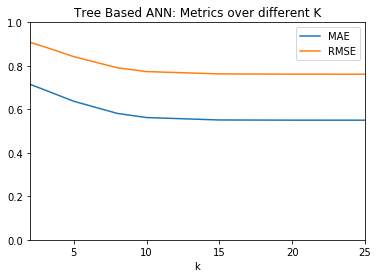

In [440]:
plot1 = results_df1.plot(x='Nearest Neighbors', y=['MAE', 'RMSE'], ylim=(0,1), title = 'Item-Item CF: Metrics over different K')
df_results.plot(x='k', y=['MAE', 'RMSE'], ylim=(0,1), title = 'Tree Based ANN: Metrics over different K')

In [448]:
# Code to compare timings
n=tree.shape[1]
check_mat = np.zeros(item_similarity.shape)

for k in range(n):
    indices = np.argwhere(tree[:, k]==1).flatten()
    for i in indices:
        for j in indices:
            check_mat[i][j] = 1

print(len(check_mat[check_mat==1].flatten())/(4959*4959))

0.9692893706615664
